<a href="https://colab.research.google.com/github/BrainConnection/Dynamical_Decoupling_Project/blob/main/6.%201Q%20DD%20Dephasing%20Optimization%20(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Environment Setting



In [1]:
!pip install qutip
!pip install numpy
!pip install matplotlib
!pip install scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 14.3 MB/s eta 0:00:00


In [2]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
from scipy.optimize import curve_fit, minimize

# CP CPMG UDD XY4 XY8 XY16 Sequence

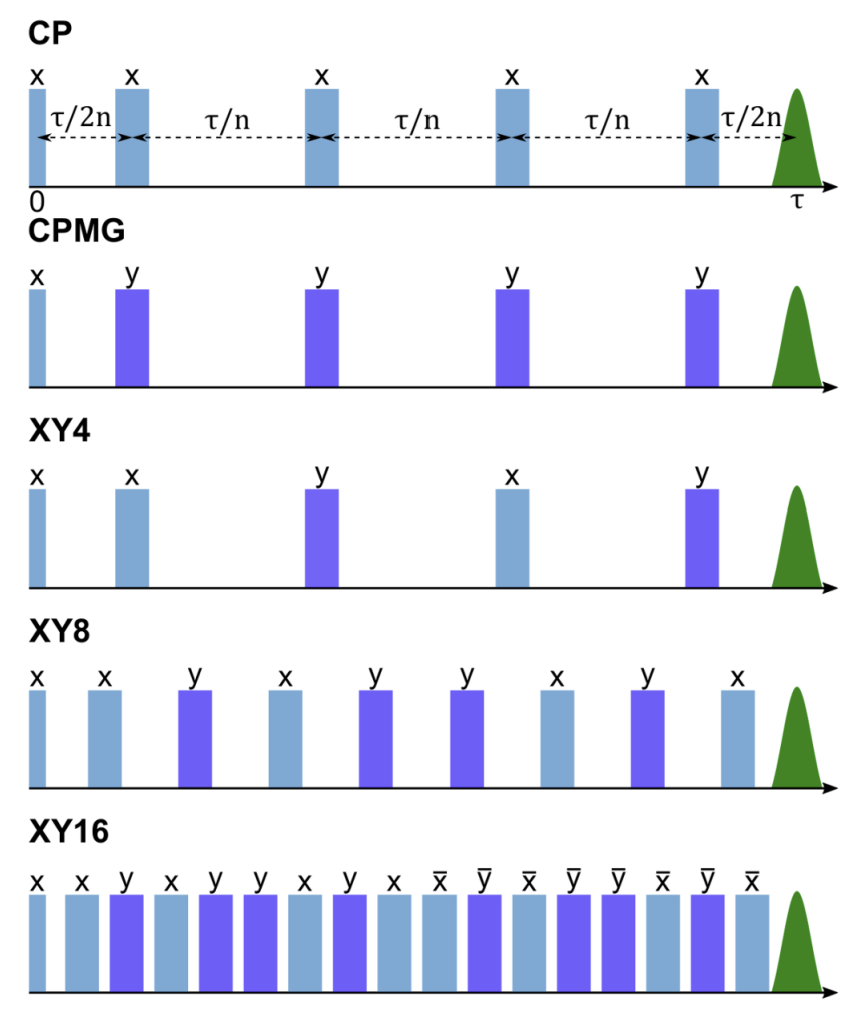

In [8]:
# Modulate each pulse timing (Equivalent Spacing)
# pulse list
# skip pi/2 pulse at T_srt, T_end
# pi pulse at pulse time list

def Pulse_Timing(T_srt, T_end, N):

    T = T_end - T_srt
    Seq_list = []
    for i in range(N):
      Seq_list.append(T_srt + (2*i+1)*T/(2*N))

    Seq = np.array(Seq_list)

    return Seq


# Modulate each pulse timing (Sinusoidal Spacing)
# pulse list
# skip pi/2 pulse at T_srt, T_end
# pi pulse at pulse time list

def Pulse_Timing_UDD(T_srt, T_end, N):

    T = T_end - T_srt
    Seq_list = []

    shift = 0
    for i in range(N):
      shift = shift + T * np.sin(np.pi/(2*(N+2))) * np.sin(np.pi*(i+1)/(N+2)) / np.cos(np.pi/(2*(N+2)))
      Seq_list.append(T_srt + shift)

    Seq = np.array(Seq_list)

    return Seq

In [9]:
# Single Square Pulse Envolope

def Single_pulse_env(t, B, T_cent):

    return B * (t > T_cent-0.5*np.pi/B) * (t < T_cent+0.5*np.pi/B)


# Single Square Pulse (lab frame)

def Single_pulse(t, B, Omega_qd, T_cent, Phi_qd):

    return Single_pulse_env(t, B, T_cent) * np.cos(Omega_qd * t + Phi_qd)

In [10]:
# time-dependent coefficient for resonator drive

def Hrd_rotating_frame(t, args):
    """
    Envelope function for the readout drive
    """
    A = args['A'] # amplitude of the readout drive
    T_srt = args['T_srt_r'] # duration of the readout drive, in units of ns
    T_end = args['T_end_r'] # duration of the readout drive, in units of ns

    return A * (T_srt <= t) * (t <= T_end)


def Hrd_lab_frame(t, args):
    omega_rd = args['Omega_rd']
    return Hrd_rotating_frame(t, args) * np.cos(omega_rd * t)

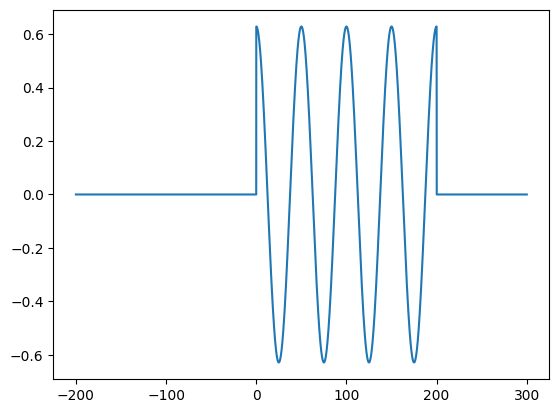

In [11]:
# resonator drive pulse simulation

tlist = np.linspace(-200, 300, 10000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*0.1, 'T_srt_r': 0, 'T_end_r': 200, 'Omega_rd': 2*np.pi*0.02}))

## CP CPMG UDD Sequence

In [12]:
# CP (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N_seq (number of pulse)

def CP_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    N = args['N_seq']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, N)
    pulse = 0

    for T_cent in Seq:
      pulse = pulse + Single_pulse(t, B, Omega_qd, T_cent, 0)

    return pulse

In [13]:
# CPMG (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N_seq (number of pulse)

def CPMG_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    N = args['N_seq']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, N)
    pulse = 0

    for T_cent in Seq:
      pulse = pulse + Single_pulse(t, B, Omega_qd, T_cent, 0.5*np.pi)

    return pulse

In [14]:
# CPMG (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N_seq (number of pulse)

def UDD_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    N = args['N_seq']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing_UDD(T_srt, T_end, N)
    pulse = 0

    for T_cent in Seq:
      pulse = pulse + Single_pulse(t, B, Omega_qd, T_cent, 0.5*np.pi)

    return pulse

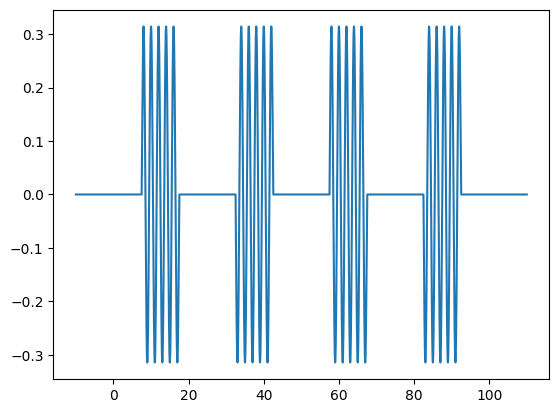

In [15]:
# qubit drive pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, CP_lab_frame(tlist, {'B': 2*np.pi*0.05, 'T_srt_q': 0, 'T_end_q': 100, 'N_seq': 4, 'Omega_qd': 2*np.pi*0.5}))

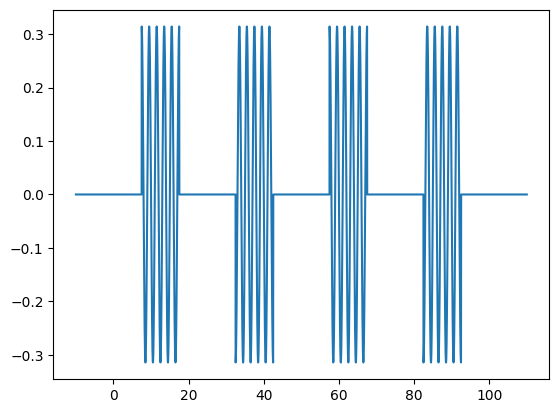

In [16]:
# qubit drive pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, CPMG_lab_frame(tlist, {'B': 2*np.pi*0.05, 'T_srt_q': 0, 'T_end_q': 100, 'N_seq': 4, 'Omega_qd': 2*np.pi*0.5}))

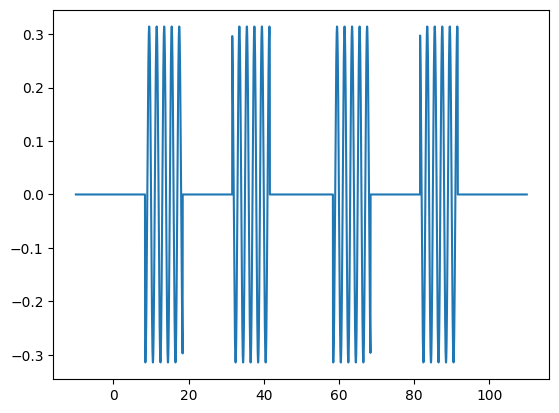

In [17]:
# qubit drive pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, UDD_lab_frame(tlist, {'B': 2*np.pi*0.05, 'T_srt_q': 0, 'T_end_q': 100, 'N_seq': 4, 'Omega_qd': 2*np.pi*0.5}))

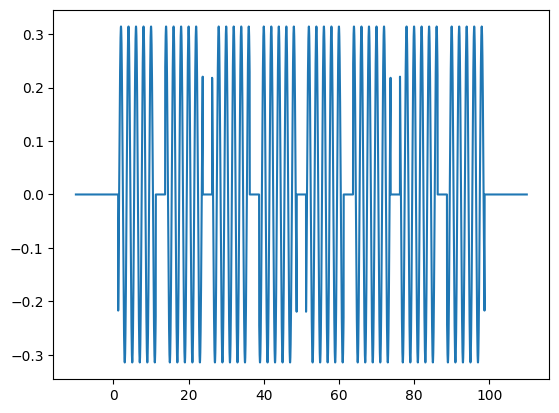

In [18]:
# qubit drive pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, CP_lab_frame(tlist, {'B': 2*np.pi*0.05, 'T_srt_q': 0, 'T_end_q': 100, 'N_seq': 8, 'Omega_qd': 2*np.pi*0.5}))

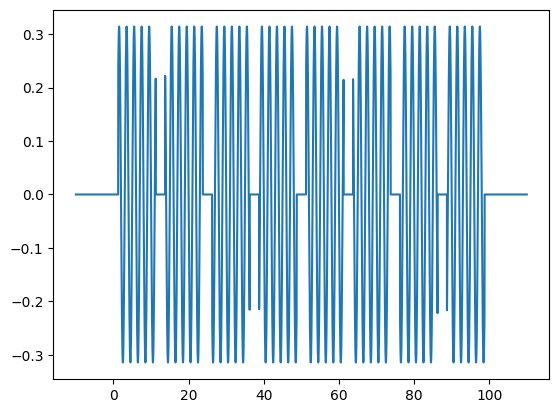

In [19]:
# qubit drive pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, CPMG_lab_frame(tlist, {'B': 2*np.pi*0.05, 'T_srt_q': 0, 'T_end_q': 100, 'N_seq': 8, 'Omega_qd': 2*np.pi*0.5}))

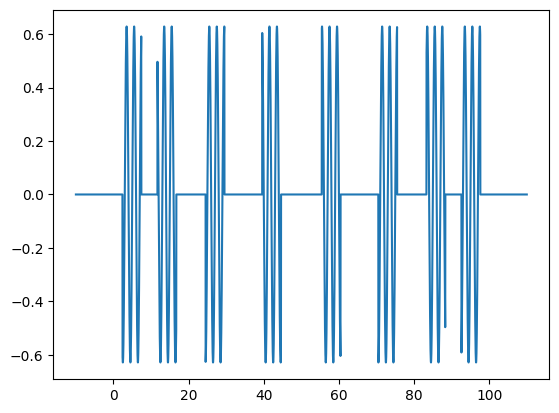

In [20]:
# qubit drive pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, UDD_lab_frame(tlist, {'B': 2*np.pi*0.1, 'T_srt_q': 0, 'T_end_q': 100, 'N_seq': 8, 'Omega_qd': 2*np.pi*0.5}))

## XY4 XY8 XY16 Sequence

In [21]:
# XY4 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def XY4_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, 4)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    return pulse

In [22]:
# XY8 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def XY8_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, 8)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[4], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[5], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[6], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[7], 0)

    return pulse

In [23]:
# XY16 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def XY16_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, 16)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[4], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[5], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[6], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[7], 0)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[8], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[9], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[10], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[11], 1.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[12], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[13], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[14], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[15], np.pi)

    return pulse

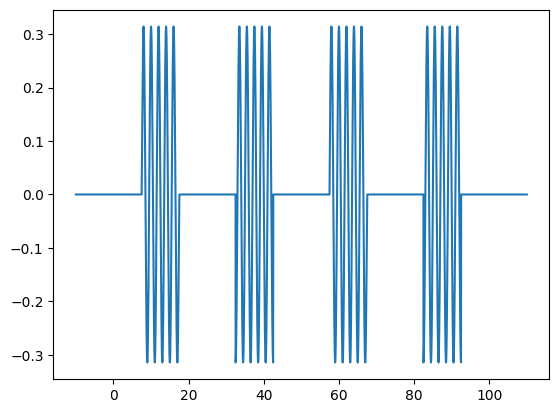

In [24]:
# qubit pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, XY4_lab_frame(tlist, {'B': 2*np.pi*0.05, 'T_srt_q': 0, 'T_end_q': 100, 'Omega_qd': 2*np.pi*0.5}))

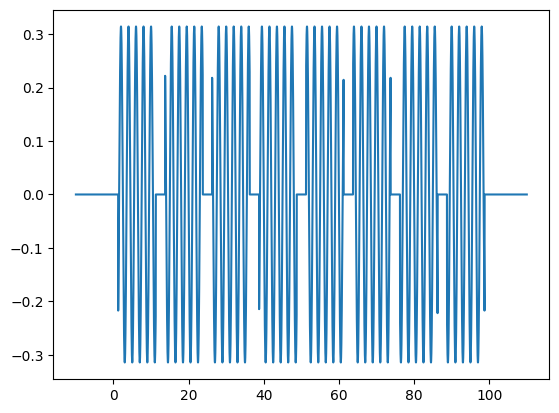

In [25]:
# qubit pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, XY8_lab_frame(tlist, {'B': 2*np.pi*0.05, 'T_srt_q': 0, 'T_end_q': 100, 'Omega_qd': 2*np.pi*0.5}))

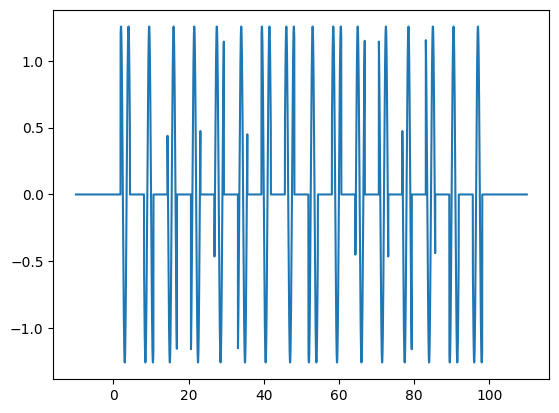

In [26]:
# qubit pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, XY16_lab_frame(tlist, {'B': 2*np.pi*0.2, 'T_srt_q': 0, 'T_end_q': 100, 'Omega_qd': 2*np.pi*0.5}))

## UDD4 UDD8 UDD16 Sequence

In [27]:
# UDD4 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def UDD4_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing_UDD(T_srt, T_end, 4)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    return pulse

In [28]:
# UDD8 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def UDD8_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing_UDD(T_srt, T_end, 8)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[4], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[5], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[6], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[7], 0)

    return pulse

In [29]:
# UDD16 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def UDD16_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing_UDD(T_srt, T_end, 16)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[4], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[5], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[6], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[7], 0)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[8], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[9], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[10], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[11], 1.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[12], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[13], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[14], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[15], np.pi)

    return pulse

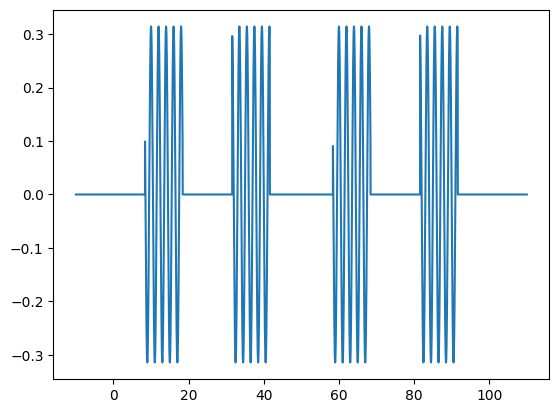

In [30]:
# qubit pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, UDD4_lab_frame(tlist, {'B': 2*np.pi*0.05, 'T_srt_q': 0, 'T_end_q': 100, 'Omega_qd': 2*np.pi*0.5}))

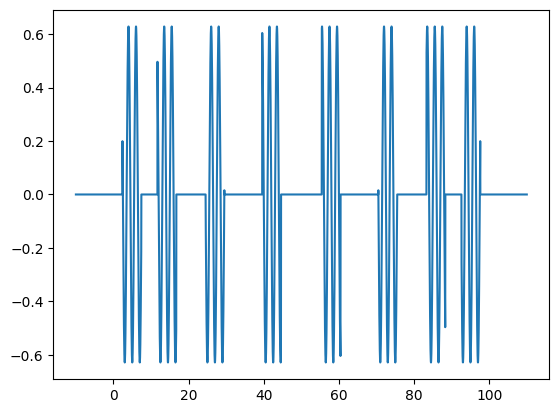

In [31]:
# qubit pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, UDD8_lab_frame(tlist, {'B': 2*np.pi*0.1, 'T_srt_q': 0, 'T_end_q': 100, 'Omega_qd': 2*np.pi*0.5}))

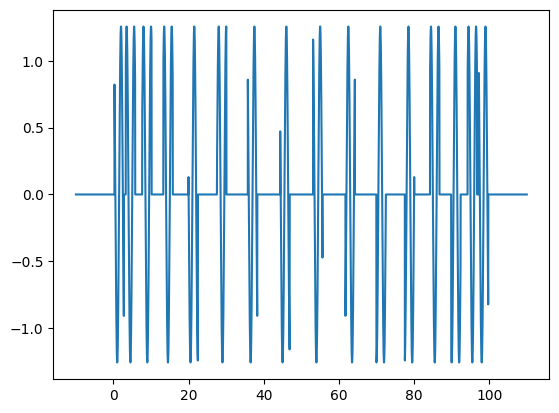

In [32]:
# qubit pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, UDD16_lab_frame(tlist, {'B': 2*np.pi*0.2, 'T_srt_q': 0, 'T_end_q': 100, 'Omega_qd': 2*np.pi*0.5}))

# Qubit Drive Frequency Determination

## Setting

In [87]:
# readout resonator & purcell filter resonator dimension

N = 3


# constant

B = 0.1 * 2 * np.pi

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.01        # qubit-resonator coupling in units of GHz
kappa_f = 2 * np.pi * 0.05  # external coupling rate of resonator in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi

# operator defined on bare basis

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_bare                 = tensor(sx, qeye(N), qeye(N))
sy_bare                 = tensor(sy, qeye(N), qeye(N))
sz_bare                 = tensor(sz, qeye(N), qeye(N))
sp_bare                 = tensor(sp, qeye(N), qeye(N))
sm_bare                 = tensor(sm, qeye(N), qeye(N))

readout_annihilate_bare = tensor(qeye(2), a, qeye(N))
readout_create_bare     = tensor(qeye(2), a.dag(), qeye(N))
readout_number_bare     = tensor(qeye(2), a.dag()*a, qeye(N))

filter_annihilate_bare  = tensor(qeye(2), qeye(N), b)
filter_create_bare      = tensor(qeye(2), qeye(N), b.dag())
filter_number_bare      = tensor(qeye(2), qeye(N), b.dag()*b)

psi0_bare               = tensor(basis(2,0), basis(N,0), basis(N,0))
psis_bare               = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi1_bare               = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_bare + omega_r*readout_number_bare + omega_f*filter_number_bare + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_bare

tot_coherence_list_2 = []
tau_list = np.array([100*(k+3) for k in range(8)])

In [88]:
sx_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][1].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][5].dag() \
+ H0.eigenstates()[1][3]*H0.eigenstates()[1][4].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][10].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() + H0.eigenstates()[1][8]*H0.eigenstates()[1][11].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][15].dag() + H0.eigenstates()[1][13]*H0.eigenstates()[1][14].dag() \
+ H0.eigenstates()[1][16]*H0.eigenstates()[1][17].dag() \
+ H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


sy_dressed = + (-1j)*H0.eigenstates()[1][0]*H0.eigenstates()[1][1].dag() + (-1j)*H0.eigenstates()[1][2]*H0.eigenstates()[1][5].dag() \
+ (-1j)*H0.eigenstates()[1][3]*H0.eigenstates()[1][4].dag() + (-1j)*H0.eigenstates()[1][6]*H0.eigenstates()[1][10].dag() \
+ (-1j)*H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() + (-1j)*H0.eigenstates()[1][8]*H0.eigenstates()[1][11].dag() \
+ (-1j)*H0.eigenstates()[1][12]*H0.eigenstates()[1][15].dag() + (-1j)*H0.eigenstates()[1][13]*H0.eigenstates()[1][14].dag() \
+ (-1j)*H0.eigenstates()[1][16]*H0.eigenstates()[1][17].dag() \
+ (+1j)*H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + (+1j)*H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ (+1j)*H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + (+1j)*H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ (+1j)*H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + (+1j)*H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ (+1j)*H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + (+1j)*H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ (+1j)*H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


sz_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() \
- H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag() - H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() \
- H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() - H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
- H0.eigenstates()[1][10]*H0.eigenstates()[1][10].dag() - H0.eigenstates()[1][11]*H0.eigenstates()[1][11].dag() \
- H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() - H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
- H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag()


sp_dressed = H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


readout_number_dressed = H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() \
+ 2*H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() + 2*H0.eigenstates()[1][11]*H0.eigenstates()[1][11].dag() \
+ 2*H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() + 2*H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
+ 2*H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() + 2*H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag() \


filter_number_dressed = H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
+ H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() + H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
+ 2*H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() + 2*H0.eigenstates()[1][10]*H0.eigenstates()[1][10].dag() \
+ 2*H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + 2*H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() \
+ 2*H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() + 2*H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag()

In [89]:
psi0_dressed             = H0.eigenstates()[1][0]
psi1_dressed             = H0.eigenstates()[1][1]
psis_dressed             = (psi0_dressed + psi1_dressed)/np.sqrt(2)

op_list = [sx_dressed, sy_dressed, sz_dressed, sp_dressed, readout_number_dressed, filter_number_dressed, readout_number_bare, filter_number_bare]

## Ramsey A = 0.0025

$\omega_{qd} = \omega_q + \chi$

In [90]:
# Simulation

N_seq = 0
A = 0.0025 * 2 * np.pi
omega_qd = omega_q + chi

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 300, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

x_rot = + np.cos(omega_qd*tlist) * result.expect[0] - np.sin(omega_qd*tlist) * result.expect[1]
y_rot = + np.sin(omega_qd*tlist) * result.expect[0] + np.cos(omega_qd*tlist) * result.expect[1]

print("dressed readout photon number : {0}".format(result.expect[4][-1]))
print("dressed filter photon number : {0}".format(result.expect[5][-1]))
print("bare readout photon number : {0}".format(result.expect[6][-1]))
print("bare filter photon number : {0}".format(result.expect[7][-1]))

dressed readout photon number : 0.0107936299784028
dressed filter photon number : 0.005517511003454913
bare readout photon number : 0.016894477252020448
bare filter photon number : 0.0022233771105448293


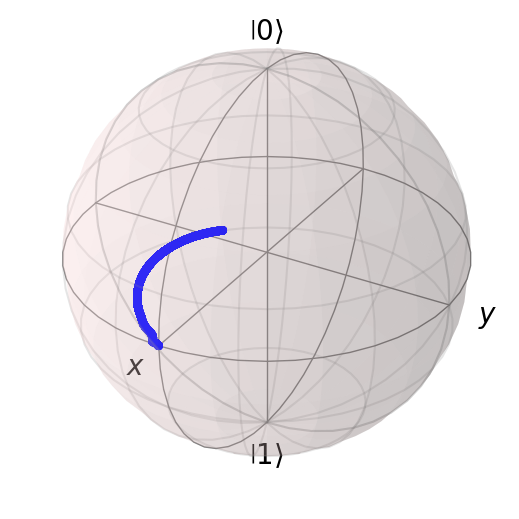

In [91]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([x_rot, y_rot, result.expect[2]]), meth="s")
sphere.show()

Text(0, 0.5, 'Z')

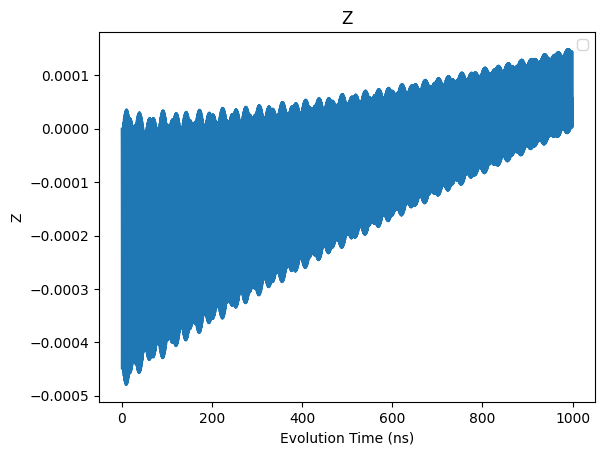

In [92]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.legend()
plt.title('Z')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Z')

0.30795357399211426


Text(0, 0.5, 'Coherence')

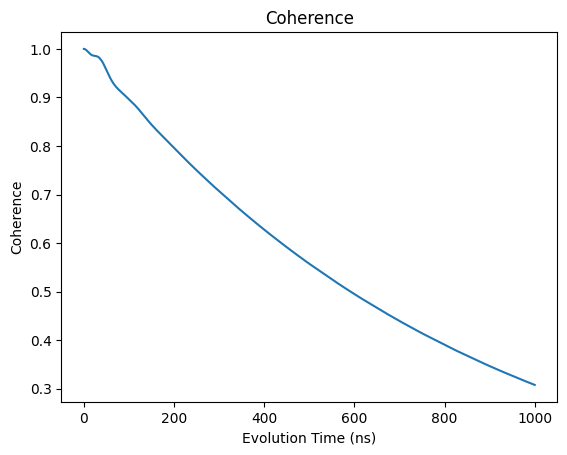

In [93]:
# Plot Results

print(2*np.abs(result.expect[3][-1]))

plt.plot(tlist, 2*np.abs(result.expect[3]))

plt.title('Coherence')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Coherence')

## Ramsey A = 0.0025

$\omega_{qd} = 37.638$

In [98]:
# Simulation

N_seq = 0
A = 0.0025 * 2 * np.pi
omega_qd = 37.638

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 300, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

x_rot = + np.cos(omega_qd*tlist) * result.expect[0] - np.sin(omega_qd*tlist) * result.expect[1]
y_rot = + np.sin(omega_qd*tlist) * result.expect[0] + np.cos(omega_qd*tlist) * result.expect[1]

print("dressed readout photon number : {0}".format(result.expect[4][-1]))
print("dressed filter photon number : {0}".format(result.expect[5][-1]))
print("bare readout photon number : {0}".format(result.expect[6][-1]))
print("bare filter photon number : {0}".format(result.expect[7][-1]))

dressed readout photon number : 0.0107936299784028
dressed filter photon number : 0.005517511003454913
bare readout photon number : 0.016894477252020448
bare filter photon number : 0.0022233771105448293


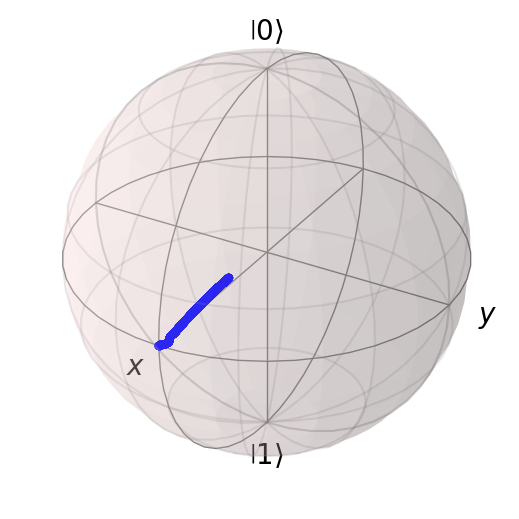

In [99]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([x_rot, y_rot, result.expect[2]]), meth="s")
sphere.show()

Text(0, 0.5, 'Z')

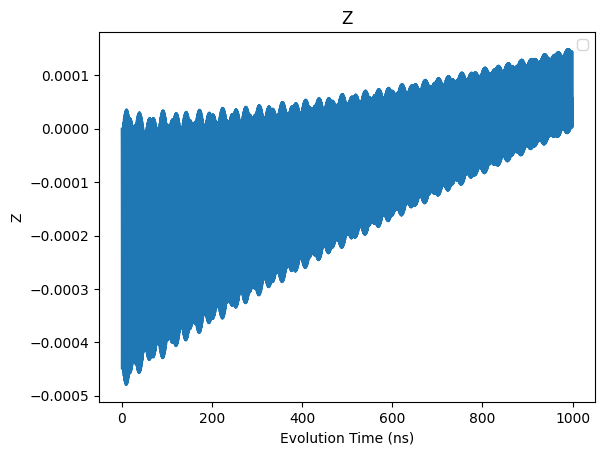

In [100]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.legend()
plt.title('Z')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Z')

0.30795357399211426


Text(0, 0.5, 'Coherence')

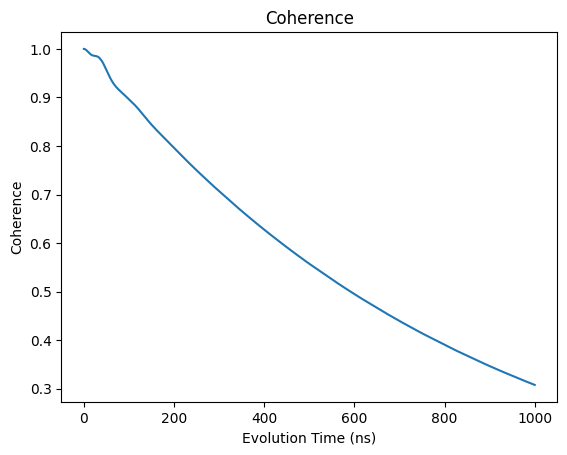

In [101]:
# Plot Results

print(2*np.abs(result.expect[3][-1]))

plt.plot(tlist, 2*np.abs(result.expect[3]))

plt.title('Coherence')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Coherence')

## Ramsey A = 0.0025

$\omega_{qd} = 37.6381$

In [102]:
# Simulation

N_seq = 0
A = 0.0025 * 2 * np.pi
omega_qd = 37.6381

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 300, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

x_rot = + np.cos(omega_qd*tlist) * result.expect[0] - np.sin(omega_qd*tlist) * result.expect[1]
y_rot = + np.sin(omega_qd*tlist) * result.expect[0] + np.cos(omega_qd*tlist) * result.expect[1]

print("dressed readout photon number : {0}".format(result.expect[4][-1]))
print("dressed filter photon number : {0}".format(result.expect[5][-1]))
print("bare readout photon number : {0}".format(result.expect[6][-1]))
print("bare filter photon number : {0}".format(result.expect[7][-1]))

dressed readout photon number : 0.0107936299784028
dressed filter photon number : 0.005517511003454913
bare readout photon number : 0.016894477252020448
bare filter photon number : 0.0022233771105448293


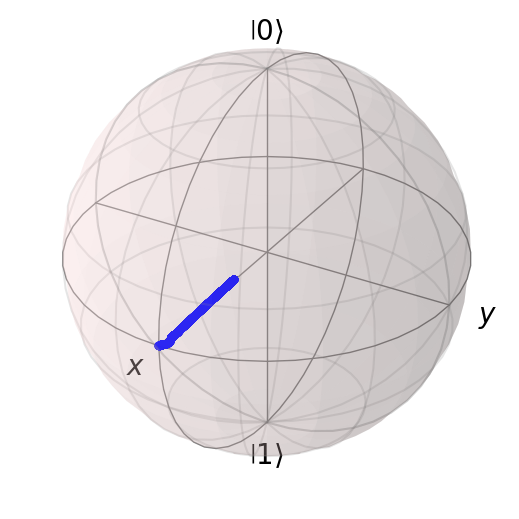

In [103]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([x_rot, y_rot, result.expect[2]]), meth="s")
sphere.show()

Text(0, 0.5, 'Z')

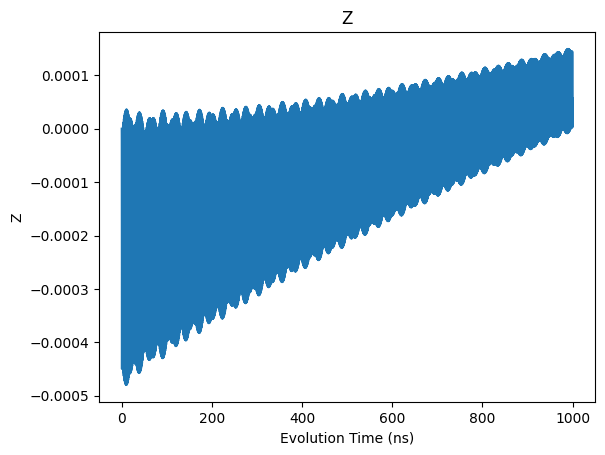

In [104]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.title('Z')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Z')

0.30795357399211426


Text(0, 0.5, 'Coherence')

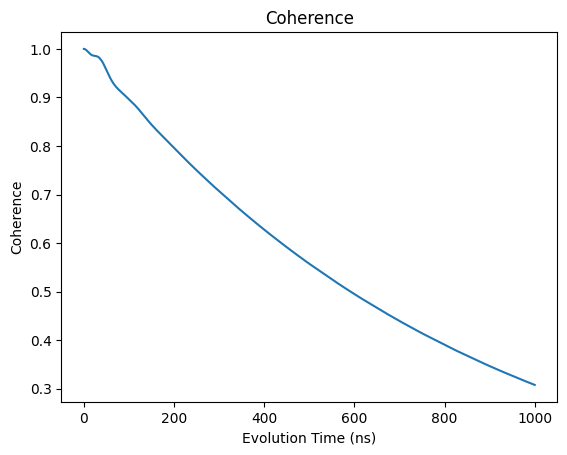

In [105]:
# Plot Results

print(2*np.abs(result.expect[3][-1]))

plt.plot(tlist, 2*np.abs(result.expect[3]))

plt.title('Coherence')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Coherence')

## Ramsey A = 0.0025

$\omega_{qd} = 37.6382$

In [106]:
# Simulation

N_seq = 0
A = 0.0025 * 2 * np.pi
omega_qd = 37.6382

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 300, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

x_rot = + np.cos(omega_qd*tlist) * result.expect[0] - np.sin(omega_qd*tlist) * result.expect[1]
y_rot = + np.sin(omega_qd*tlist) * result.expect[0] + np.cos(omega_qd*tlist) * result.expect[1]

print("dressed readout photon number : {0}".format(result.expect[4][-1]))
print("dressed filter photon number : {0}".format(result.expect[5][-1]))
print("bare readout photon number : {0}".format(result.expect[6][-1]))
print("bare filter photon number : {0}".format(result.expect[7][-1]))

dressed readout photon number : 0.0107936299784028
dressed filter photon number : 0.005517511003454913
bare readout photon number : 0.016894477252020448
bare filter photon number : 0.0022233771105448293


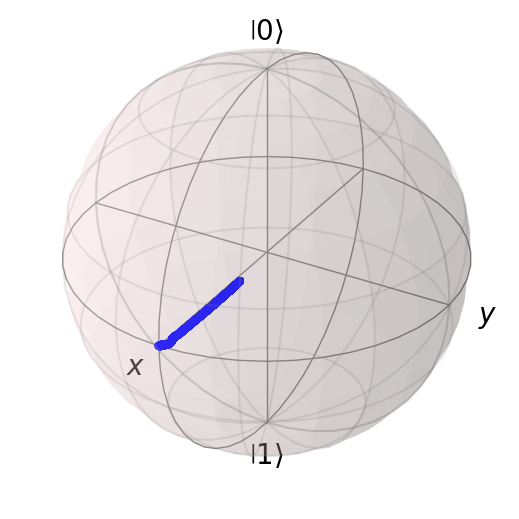

In [107]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([x_rot, y_rot, result.expect[2]]), meth="s")
sphere.show()

Text(0, 0.5, 'Z')

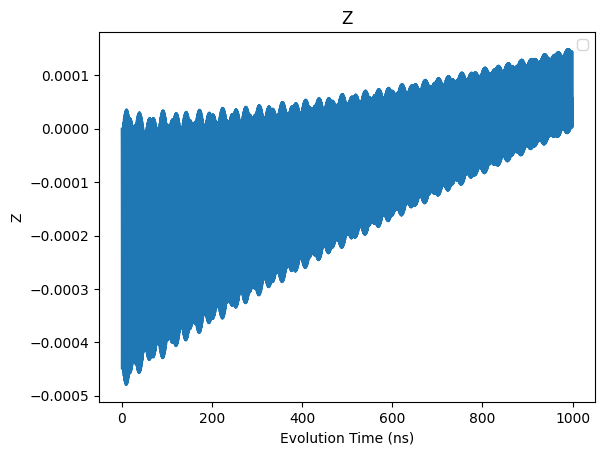

In [108]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.legend()
plt.title('Z')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Z')

0.30795357399211426


Text(0, 0.5, 'Coherence')

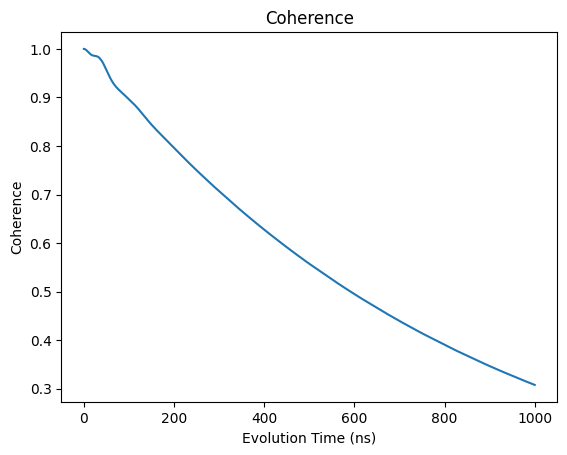

In [109]:
# Plot Results

print(2*np.abs(result.expect[3][-1]))

plt.plot(tlist, 2*np.abs(result.expect[3]))

plt.title('Coherence')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Coherence')

## Ramsey A = 0.0025

$\omega_{qd} = 37.65$

In [110]:
# Simulation

N_seq = 0
A = 0.0025 * 2 * np.pi
omega_qd = 37.65

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 300, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

x_rot = + np.cos(omega_qd*tlist) * result.expect[0] - np.sin(omega_qd*tlist) * result.expect[1]
y_rot = + np.sin(omega_qd*tlist) * result.expect[0] + np.cos(omega_qd*tlist) * result.expect[1]

print("dressed readout photon number : {0}".format(result.expect[4][-1]))
print("dressed filter photon number : {0}".format(result.expect[5][-1]))
print("bare readout photon number : {0}".format(result.expect[6][-1]))
print("bare filter photon number : {0}".format(result.expect[7][-1]))

dressed readout photon number : 0.0107936299784028
dressed filter photon number : 0.005517511003454913
bare readout photon number : 0.016894477252020448
bare filter photon number : 0.0022233771105448293


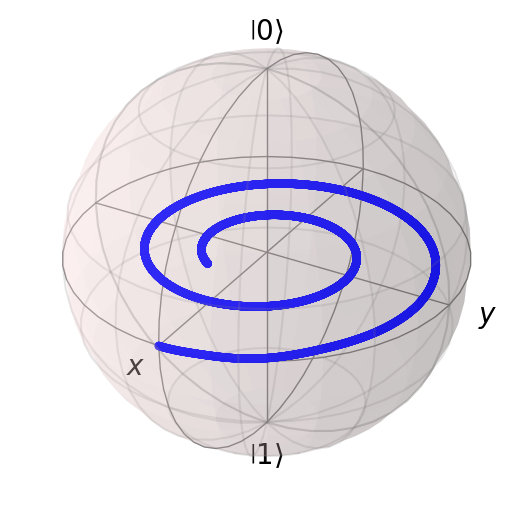

In [111]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([x_rot, y_rot, result.expect[2]]), meth="s")
sphere.show()

Text(0, 0.5, 'Z')

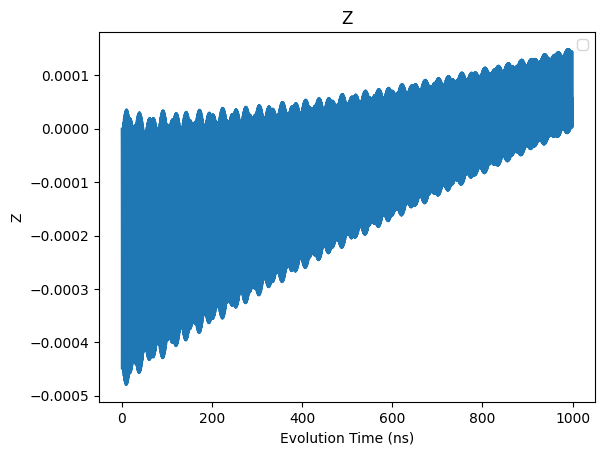

In [112]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.legend()
plt.title('Z')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Z')

0.30795357399211426


Text(0, 0.5, 'Coherence')

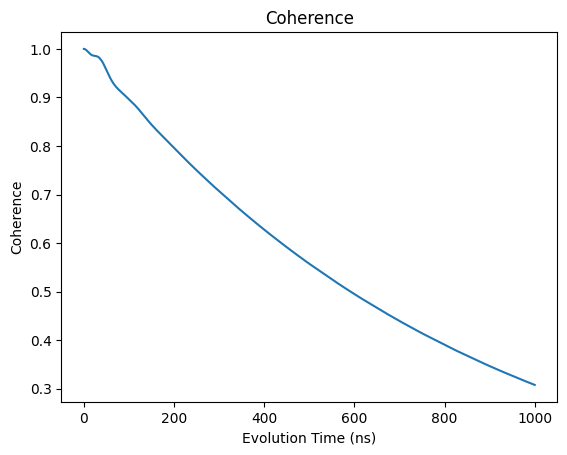

In [113]:
# Plot Results

print(2*np.abs(result.expect[3][-1]))

plt.plot(tlist, 2*np.abs(result.expect[3]))

plt.title('Coherence')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Coherence')

# Effect of $π$-pulse

## Ramsey A = 0.0025

$\omega_{qd} = 37.0000$

In [120]:
# Simulation

N_seq = 1
A = 0.0025 * 2 * np.pi
omega_qd = 37.0000

tlist = np.linspace(0, 5, 500)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CPMG_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 5, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

x_rot = + np.cos(omega_qd*tlist) * result.expect[0] - np.sin(omega_qd*tlist) * result.expect[1]
y_rot = + np.sin(omega_qd*tlist) * result.expect[0] + np.cos(omega_qd*tlist) * result.expect[1]

print("dressed readout photon number : {0}".format(result.expect[4][-1]))
print("dressed filter photon number : {0}".format(result.expect[5][-1]))
print("bare readout photon number : {0}".format(result.expect[6][-1]))
print("bare filter photon number : {0}".format(result.expect[7][-1]))

dressed readout photon number : 0.0009742572939606889
dressed filter photon number : 0.0003863776905426821
bare readout photon number : 0.0071793456890722205
bare filter photon number : 2.182128501420208e-05


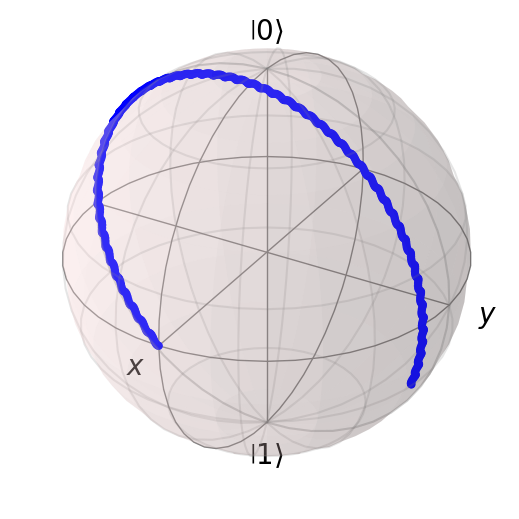

In [121]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([x_rot, y_rot, result.expect[2]]), meth="s")
sphere.show()

Text(0, 0.5, 'X')

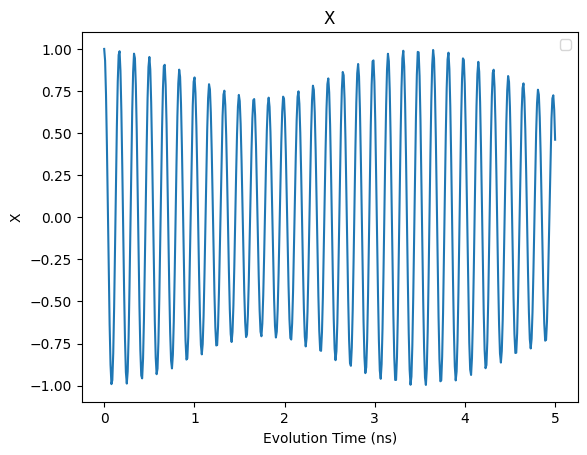

In [122]:
# Plot Results

plt.plot(tlist, result.expect[0])

plt.legend()
plt.title('X')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('X')

Text(0, 0.5, 'Y')

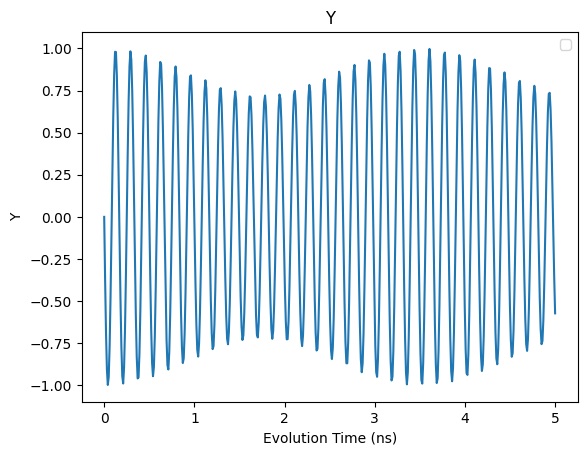

In [123]:
# Plot Results

plt.plot(tlist, result.expect[1])

plt.legend()
plt.title('Y')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Y')

Text(0, 0.5, 'Z')

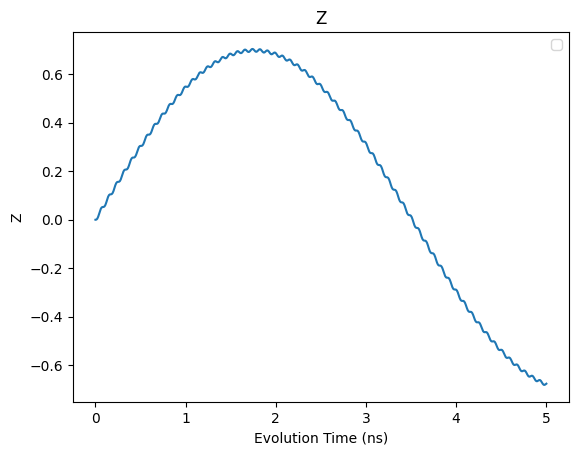

In [125]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.legend()
plt.title('Z')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Z')

## Ramsey A = 0.0025

$\omega_{qd} = 37.6381$

In [126]:
# Simulation

N_seq = 1
A = 0.0025 * 2 * np.pi
omega_qd = 37.6381

tlist = np.linspace(0, 5, 500)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CPMG_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 5, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

x_rot = + np.cos(omega_qd*tlist) * result.expect[0] - np.sin(omega_qd*tlist) * result.expect[1]
y_rot = + np.sin(omega_qd*tlist) * result.expect[0] + np.cos(omega_qd*tlist) * result.expect[1]

print("dressed readout photon number : {0}".format(result.expect[4][-1]))
print("dressed filter photon number : {0}".format(result.expect[5][-1]))
print("bare readout photon number : {0}".format(result.expect[6][-1]))
print("bare filter photon number : {0}".format(result.expect[7][-1]))

dressed readout photon number : 0.0011460222697459528
dressed filter photon number : 0.00043351103462701266
bare readout photon number : 0.004781618080852657
bare filter photon number : 2.7592066045275822e-05


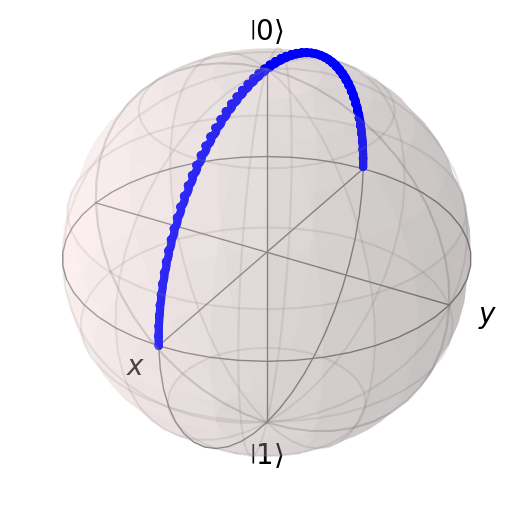

In [127]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([x_rot, y_rot, result.expect[2]]), meth="s")
sphere.show()

Text(0, 0.5, 'X')

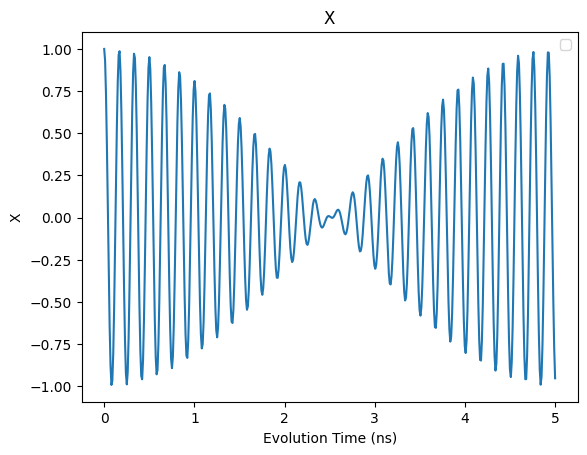

In [128]:
# Plot Results

plt.plot(tlist, result.expect[0])

plt.legend()
plt.title('X')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('X')

Text(0, 0.5, 'Y')

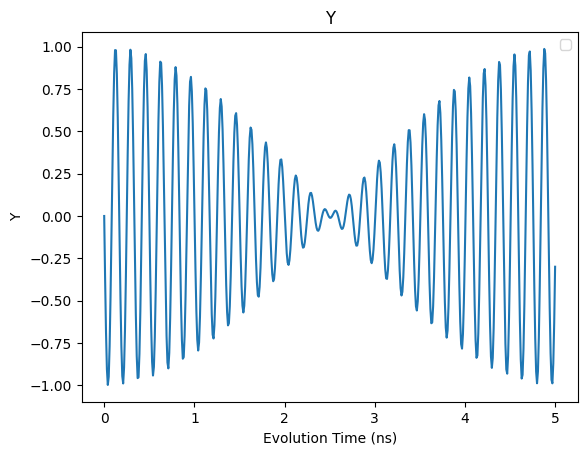

In [129]:
# Plot Results

plt.plot(tlist, result.expect[1])

plt.legend()
plt.title('Y')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Y')

Text(0, 0.5, 'Z')

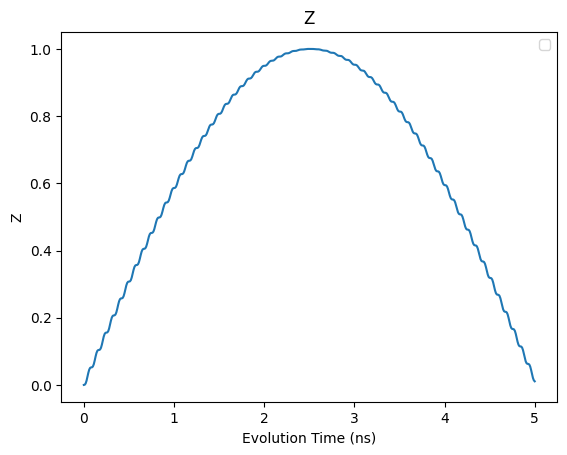

In [130]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.legend()
plt.title('Z')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Z')

## Ramsey A = 0.0025

$\omega_{qd} = 38.0000$

In [131]:
# Simulation

N_seq = 1
A = 0.0025 * 2 * np.pi
omega_qd = 38.0000

tlist = np.linspace(0, 5, 500)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CPMG_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 5, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

x_rot = + np.cos(omega_qd*tlist) * result.expect[0] - np.sin(omega_qd*tlist) * result.expect[1]
y_rot = + np.sin(omega_qd*tlist) * result.expect[0] + np.cos(omega_qd*tlist) * result.expect[1]

print("dressed readout photon number : {0}".format(result.expect[4][-1]))
print("dressed filter photon number : {0}".format(result.expect[5][-1]))
print("bare readout photon number : {0}".format(result.expect[6][-1]))
print("bare filter photon number : {0}".format(result.expect[7][-1]))

dressed readout photon number : 0.0010520378445448581
dressed filter photon number : 0.00046520736984470985
bare readout photon number : 0.010936170691187637
bare filter photon number : 2.6764531976712617e-05


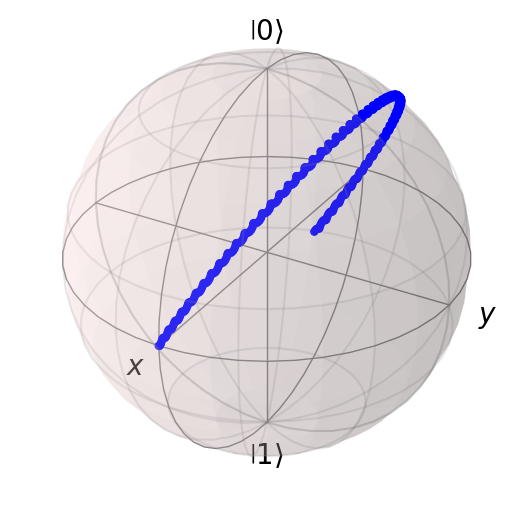

In [132]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([x_rot, y_rot, result.expect[2]]), meth="s")
sphere.show()

Text(0, 0.5, 'X')

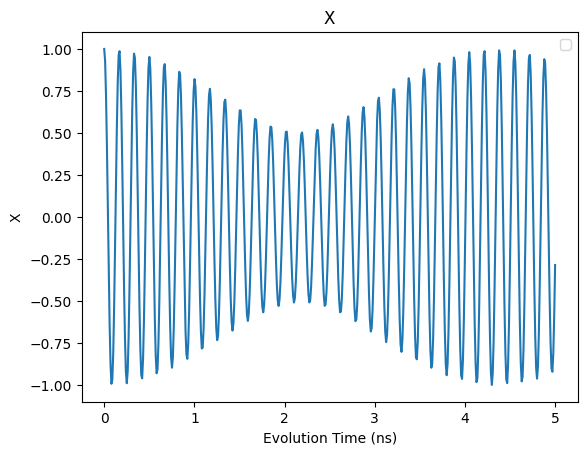

In [133]:
# Plot Results

plt.plot(tlist, result.expect[0])

plt.legend()
plt.title('X')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('X')

Text(0, 0.5, 'Y')

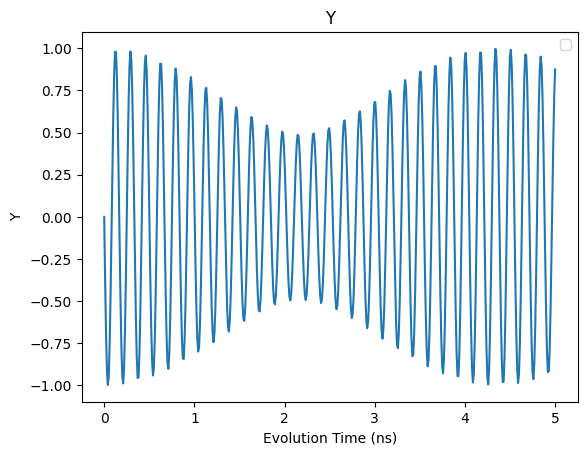

In [134]:
# Plot Results

plt.plot(tlist, result.expect[1])

plt.legend()
plt.title('Y')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Y')

Text(0, 0.5, 'Z')

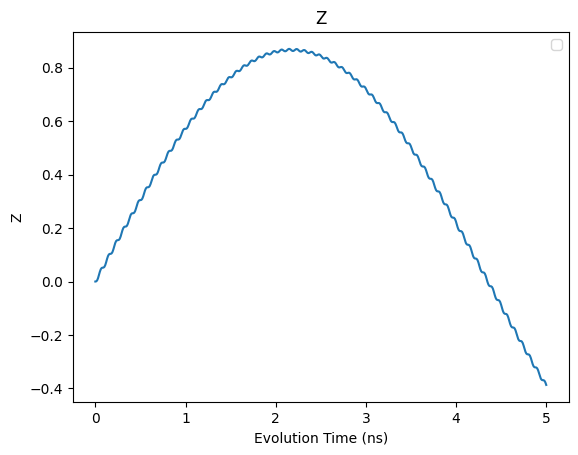

In [135]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.legend()
plt.title('Z')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Z')

## CP N=4 A = 0.0025

$\omega_{qd} = 37.0000$

In [147]:
# Simulation

N_seq = 4
A = 0.0025 * 2 * np.pi
omega_qd = 37.0000

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CPMG_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

x_rot = + np.cos(omega_qd*tlist) * result.expect[0] - np.sin(omega_qd*tlist) * result.expect[1]
y_rot = + np.sin(omega_qd*tlist) * result.expect[0] + np.cos(omega_qd*tlist) * result.expect[1]

print("dressed readout photon number : {0}".format(result.expect[4][-1]))
print("dressed filter photon number : {0}".format(result.expect[5][-1]))
print("bare readout photon number : {0}".format(result.expect[6][-1]))
print("bare filter photon number : {0}".format(result.expect[7][-1]))

dressed readout photon number : 0.011680642180317948
dressed filter photon number : 0.005827451609413271
bare readout photon number : 0.019034316124093877
bare filter photon number : 0.0023899970352529417


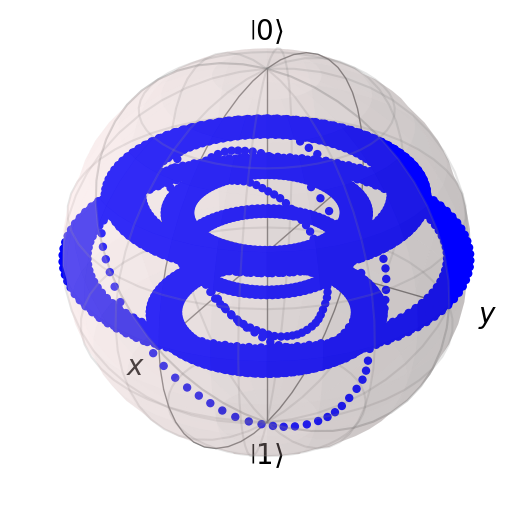

In [148]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([x_rot, y_rot, result.expect[2]]), meth="s")
sphere.show()

Text(0, 0.5, 'X')

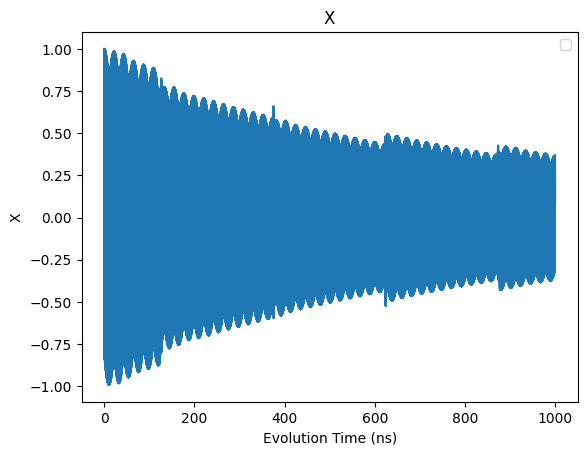

In [149]:
# Plot Results

plt.plot(tlist, result.expect[0])

plt.legend()
plt.title('X')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('X')

Text(0, 0.5, 'Y')

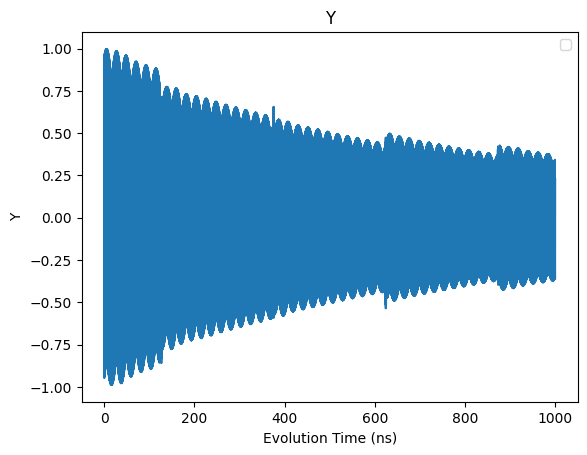

In [150]:
# Plot Results

plt.plot(tlist, result.expect[1])

plt.legend()
plt.title('Y')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Y')

Text(0, 0.5, 'Z')

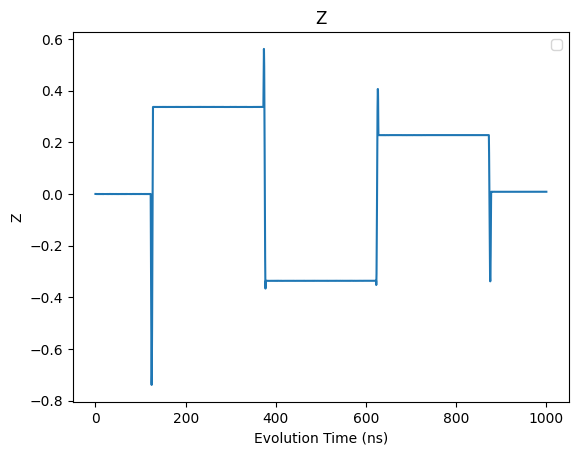

In [151]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.legend()
plt.title('Z')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Z')

## CP N=8 A = 0.0025

$\omega_{qd} = 37.0000$

In [152]:
# Simulation

N_seq = 8
A = 0.0025 * 2 * np.pi
omega_qd = 37.0000

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CPMG_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

x_rot = + np.cos(omega_qd*tlist) * result.expect[0] - np.sin(omega_qd*tlist) * result.expect[1]
y_rot = + np.sin(omega_qd*tlist) * result.expect[0] + np.cos(omega_qd*tlist) * result.expect[1]

print("dressed readout photon number : {0}".format(result.expect[4][-1]))
print("dressed filter photon number : {0}".format(result.expect[5][-1]))
print("bare readout photon number : {0}".format(result.expect[6][-1]))
print("bare filter photon number : {0}".format(result.expect[7][-1]))

dressed readout photon number : 0.010741359597405865
dressed filter photon number : 0.0054935464015955
bare readout photon number : 0.020633179376014967
bare filter photon number : 0.0025270116577827415


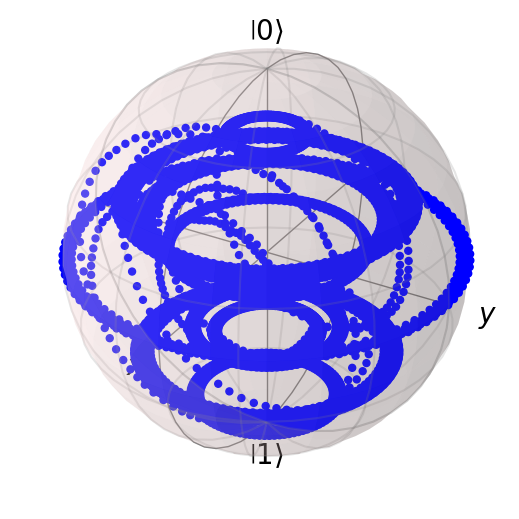

In [153]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([x_rot, y_rot, result.expect[2]]), meth="s")
sphere.show()

Text(0, 0.5, 'X')

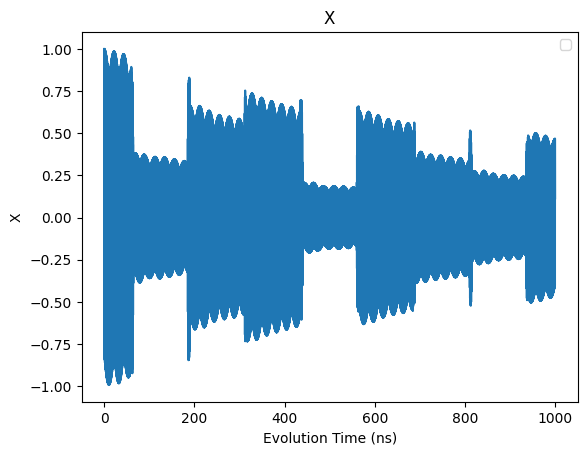

In [154]:
# Plot Results

plt.plot(tlist, result.expect[0])

plt.legend()
plt.title('X')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('X')

Text(0, 0.5, 'Y')

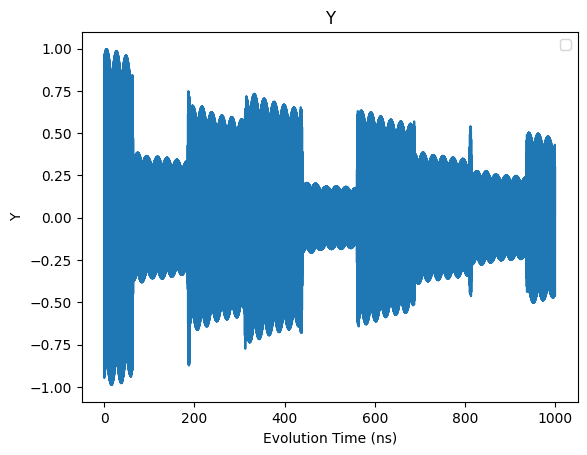

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[1])

plt.legend()
plt.title('Y')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Y')

Text(0, 0.5, 'Z')

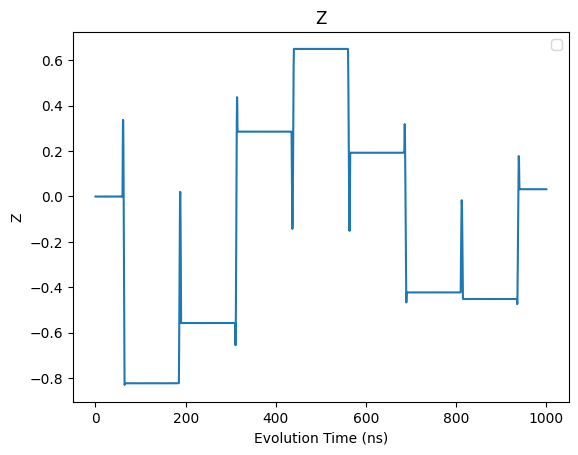

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.legend()
plt.title('Z')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Z')

## CP N=16 A = 0.0025

$\omega_{qd} = 37.0000$

In [157]:
# Simulation

N_seq = 16
A = 0.0025 * 2 * np.pi
omega_qd = 37.0000

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CPMG_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

x_rot = + np.cos(omega_qd*tlist) * result.expect[0] - np.sin(omega_qd*tlist) * result.expect[1]
y_rot = + np.sin(omega_qd*tlist) * result.expect[0] + np.cos(omega_qd*tlist) * result.expect[1]

print("dressed readout photon number : {0}".format(result.expect[4][-1]))
print("dressed filter photon number : {0}".format(result.expect[5][-1]))
print("bare readout photon number : {0}".format(result.expect[6][-1]))
print("bare filter photon number : {0}".format(result.expect[7][-1]))

dressed readout photon number : 0.022055555244159072
dressed filter photon number : 0.008660251242232346
bare readout photon number : 0.03492161859669096
bare filter photon number : 0.0036539365446079716


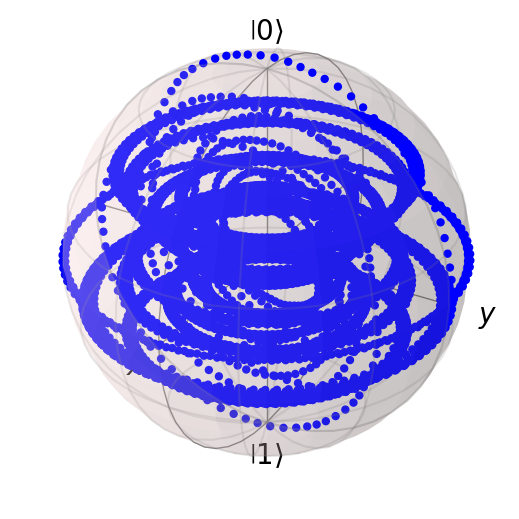

In [158]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([x_rot, y_rot, result.expect[2]]), meth="s")
sphere.show()

Text(0, 0.5, 'X')

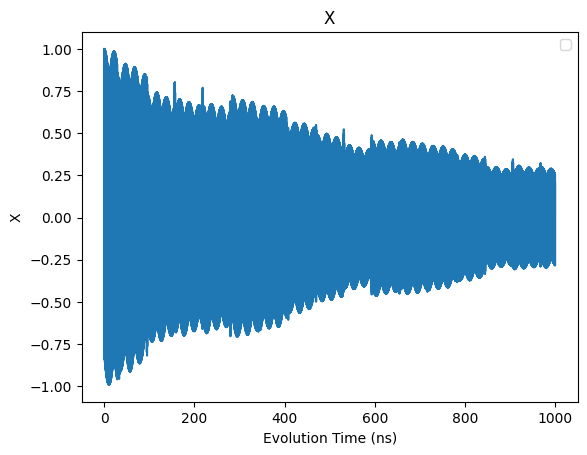

In [159]:
# Plot Results

plt.plot(tlist, result.expect[0])

plt.legend()
plt.title('X')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('X')

Text(0, 0.5, 'Y')

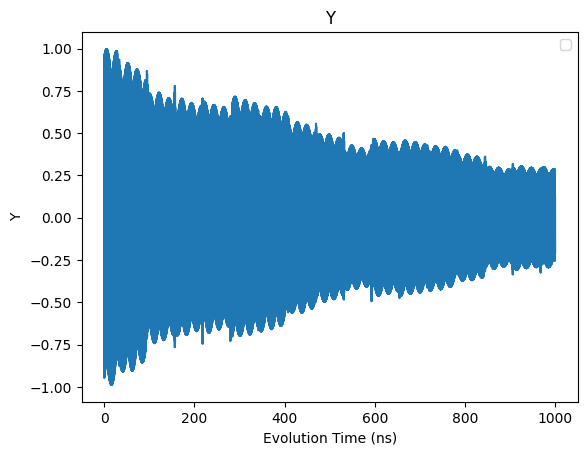

In [160]:
# Plot Results

plt.plot(tlist, result.expect[1])

plt.legend()
plt.title('Y')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Y')

Text(0, 0.5, 'Z')

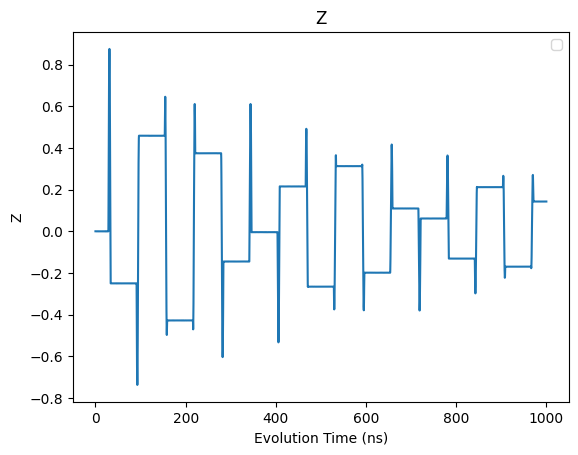

In [161]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.legend()
plt.title('Z')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Z')

## CP N=4 A = 0.0025

$\omega_{qd} = 37.6381$

In [162]:
# Simulation

N_seq = 4
A = 0.0025 * 2 * np.pi
omega_qd = 37.6381

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CPMG_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

x_rot = + np.cos(omega_qd*tlist) * result.expect[0] - np.sin(omega_qd*tlist) * result.expect[1]
y_rot = + np.sin(omega_qd*tlist) * result.expect[0] + np.cos(omega_qd*tlist) * result.expect[1]

print("dressed readout photon number : {0}".format(result.expect[4][-1]))
print("dressed filter photon number : {0}".format(result.expect[5][-1]))
print("bare readout photon number : {0}".format(result.expect[6][-1]))
print("bare filter photon number : {0}".format(result.expect[7][-1]))

dressed readout photon number : 0.01308830048363255
dressed filter photon number : 0.006321380125187392
bare readout photon number : 0.019848541634121683
bare filter photon number : 0.002658649817335224


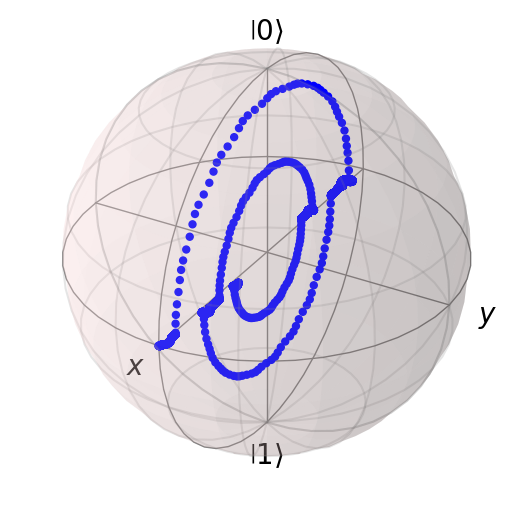

In [163]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([x_rot, y_rot, result.expect[2]]), meth="s")
sphere.show()

Text(0, 0.5, 'X')

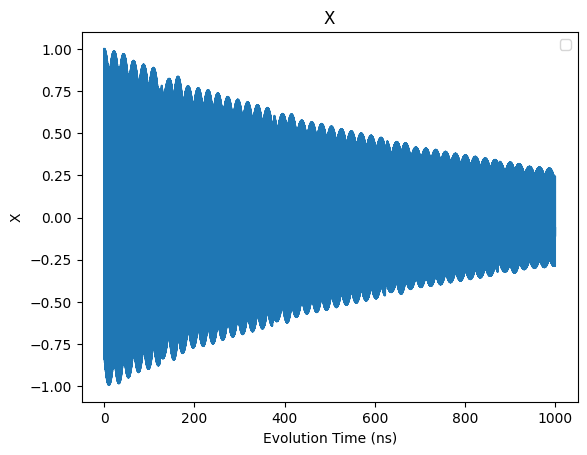

In [164]:
# Plot Results

plt.plot(tlist, result.expect[0])

plt.legend()
plt.title('X')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('X')

Text(0, 0.5, 'Y')

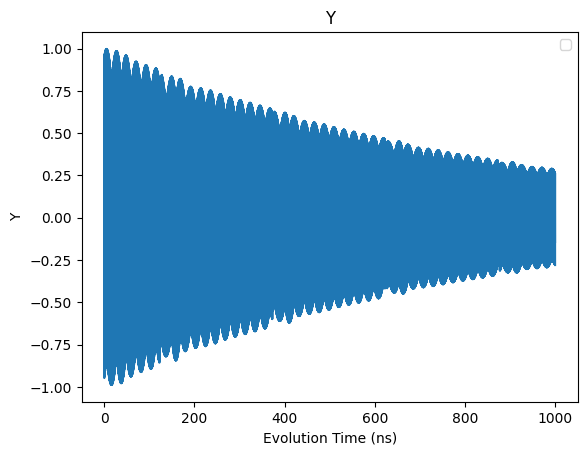

In [165]:
# Plot Results

plt.plot(tlist, result.expect[1])

plt.legend()
plt.title('Y')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Y')

Text(0, 0.5, 'Z')

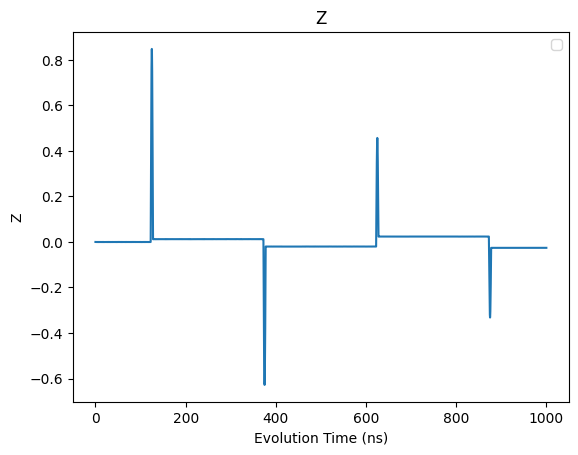

Text(0, 0.5, 'Z')

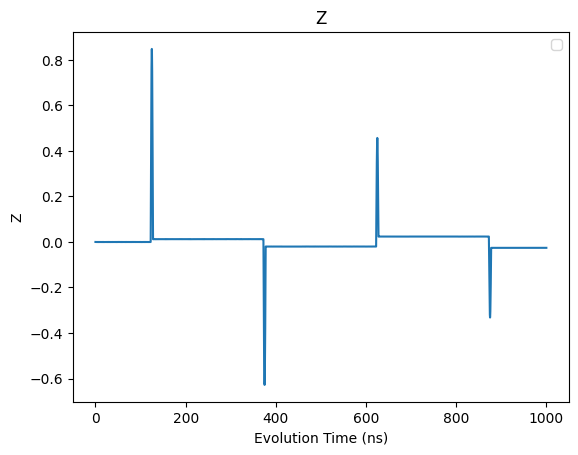

In [166]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.legend()
plt.title('Z')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Z')

## CP N=8 A = 0.0025

$\omega_{qd} = 37.6381$

In [ ]:
# Simulation

N_seq = 8
A = 0.0025 * 2 * np.pi
omega_qd = 37.6381

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CPMG_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

x_rot = + np.cos(omega_qd*tlist) * result.expect[0] - np.sin(omega_qd*tlist) * result.expect[1]
y_rot = + np.sin(omega_qd*tlist) * result.expect[0] + np.cos(omega_qd*tlist) * result.expect[1]

print("dressed readout photon number : {0}".format(result.expect[4][-1]))
print("dressed filter photon number : {0}".format(result.expect[5][-1]))
print("bare readout photon number : {0}".format(result.expect[6][-1]))
print("bare filter photon number : {0}".format(result.expect[7][-1]))

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([x_rot, y_rot, result.expect[2]]), meth="s")
sphere.show()

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[0])

plt.legend()
plt.title('X')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('X')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[1])

plt.legend()
plt.title('Y')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Y')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.legend()
plt.title('Z')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Z')

## CP N=16 A = 0.0025

$\omega_{qd} = 37.6381$

In [ ]:
# Simulation

N_seq = 16
A = 0.0025 * 2 * np.pi
omega_qd = 37.6381

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CPMG_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 1000, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

x_rot = + np.cos(omega_qd*tlist) * result.expect[0] - np.sin(omega_qd*tlist) * result.expect[1]
y_rot = + np.sin(omega_qd*tlist) * result.expect[0] + np.cos(omega_qd*tlist) * result.expect[1]

print("dressed readout photon number : {0}".format(result.expect[4][-1]))
print("dressed filter photon number : {0}".format(result.expect[5][-1]))
print("bare readout photon number : {0}".format(result.expect[6][-1]))
print("bare filter photon number : {0}".format(result.expect[7][-1]))

In [ ]:
sphere = Bloch()
sphere.zlabel = [r'$\left|0\right>$', r'$\left|1\right>$']
sphere.add_points(np.array([x_rot, y_rot, result.expect[2]]), meth="s")
sphere.show()

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[0])

plt.legend()
plt.title('X')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('X')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[1])

plt.legend()
plt.title('Y')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Y')

In [ ]:
# Plot Results

plt.plot(tlist, result.expect[2])

plt.legend()
plt.title('Z')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Z')